# LAB 3.2 - CNS (ESN)

Import of libraries and fix of random seed.


In [1]:
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
from typing import Callable
from tqdm.notebook import tqdm
import pickle

seed = 0
random.seed(seed)
np.random.seed(seed)

Loading of dataset NARMA10.

In [2]:
with open(f'NARMA10.csv') as file:
    data = file.read().split('\n')[:-1]
    X_narma10 = np.array([float(r) for r in data[0].split(',')])
    Y_narma10 = np.array([float(r) for r in data[1].split(',')])

X_narma10.shape, Y_narma10.shape

((10000,), (10000,))

Split in train and test set for each X and Y data.

In [3]:
tr_size = 5000

TR_X_narma10 = X_narma10[:tr_size].reshape(-1, 1, 1)
TR_Y_narma10 = Y_narma10[:tr_size].reshape(-1, 1)
TS_X_narma10 = X_narma10[tr_size:].reshape(-1, 1, 1)
TS_Y_narma10 = Y_narma10[tr_size:].reshape(-1, 1)

TR_X_narma10.shape, TR_Y_narma10.shape, TS_X_narma10.shape, TS_Y_narma10.shape

((5000, 1, 1), (5000, 1), (5000, 1, 1), (5000, 1))

Functions able to provide an easiest way to plot the results.

In [4]:
def _base_plot(
        elements: list[tuple],
        title: str = '',
        xlabel: str = '',
        ylabel: str = '',
        xscale=None,
        yscale=None,
        save_name=None
) -> None:
    """Function able to plot a list of elements."""
    plt.figure(figsize=(20, 10))
    plt.title(title)
    for line, label in elements:
        plt.plot(line, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xscale is not None:
        plt.xscale(xscale)
    if yscale is not None:
        plt.yscale(yscale)
    plt.grid()
    plt.legend()
    if save_name is not None:
        plt.savefig(f'esn/plots/{save_name}.png')
    plt.show()


def plot_tr(
        data: np.array,
        prediction: np.array,
        save_name: str = None
) -> None:
    """Function able to plot the training y data and predictions to make a comparison between them."""
    if save_name is not None:
        save_name = f'{save_name}_train'
    prediction = prediction.reshape(-1).tolist()
    _base_plot(
        [
            (data[-len(prediction):], 'time series'),
            (prediction, 'prediction'),
        ],
        title='Time series of training set',
        xlabel='X',
        ylabel='Y',
        save_name=save_name,
    )


def plot_ts(
        data: np.array,
        prediction: np.array,
        save_name: str = None
) -> None:
    """Function able to plot the test y data and predictions to make a comparison between them."""
    if save_name is not None:
        save_name = f'{save_name}_test'
    prediction = prediction.reshape(-1).tolist()
    _base_plot(
        [
            (data[-len(prediction):], 'time series'),
            (prediction, 'prediction'),
        ],
        title='Time series of test set',
        xlabel='X',
        ylabel='Y',
        save_name=save_name,
    )


def general_plot(
        TR_Y: np.array,
        train_pred: np.array,
        TS_Y: np.array,
        eval_pred: np.array,
        save_name: str = None
) -> None:
    """Function able to plot all results of subplots related to training data and test data."""
    plot_tr(data=TR_Y, prediction=train_pred, save_name=save_name)
    plot_ts(data=TS_Y, prediction=eval_pred, save_name=save_name)

Mean Squaare Error function.

In [5]:
def mse(Y: np.array, P: np.array) -> float:
    """
    Function able to compute the Mean Square Error between predictions and outputs.

    Y: Output values.
    P: Predictions.

    returns:
        float: Value of MSE.
    """
    if len(Y.shape) != len(P.shape):
        if len(Y.shape) > len(P.shape):
            Y = Y.argmax(-1)
        else:
            P = P.argmax(-1)
    return ((Y - P) ** 2).mean()

Import Echo State Network class model.

In [6]:
from src.model.esn import ESN

print(ESN(1, 100, 1))

ESN(w_in: (1, 100), w_hh: (100, 100), bias: (100, 1), w_out: (100, 1))


Function able to create an ESN model from a configuration and train it.

In [7]:
def create_and_train_by_config(X_TR: np.array, Y_TR: np.array, config: dict, model_constructor: Callable = ESN) -> tuple[ESN, list]:
    """
    Function able to create an ESN model from a configuration and train it.

    X_TR: Input time series.
    Y_TR: Output values.
    config: Configuration containing hyperparams.
    model_constructor: Function able to construct the model.

    returns:
        tuple[ESN, list]: Trained model and list of hidden states.
    """
    model = model_constructor(
        input_size=X_TR.shape[-1], 
        output_size=Y_TR.shape[-1], 
        **{k: v for k, v in config.items() if k not in ['reg', 'transient']},
    )
    states = model.train(
        X_TR, 
        Y_TR,
        reg=config['reg'],
        transient=config['transient'],
    )
    return model, states

Gridsearch function able to find the best configuration for a model created in a `train_func` function callback, train the model with the best configuration and test it on test set.

In [8]:
def gridsearch(
        configs: dict,
        TR: tuple[np.array, np.array],
        TS: tuple[np.array, np.array],
        vl_tr_size: int = 4000,
        attempts_for_config: int = 1,
        save_name: str = None,
        model_constructor: Callable = ESN,
) -> tuple:
    """
    Gridsearch function able to find the best hyperparameters configuration, train the model with the best config and test it.

    train_func: Function able to create a model and train it given a config, a train and validation set and a number of epochs.
    configs: Hyperparameters configurations to investigate to find the best one that minimizes the loss on validation set. In particular this is a dictionary of lists for each hyperparam to investigate that is transformed by this function in a list of dictionaries.
    TR: Training set data (X, Y).
    TS: test set data (X, Y).
    epochs: Number of epochs of training both for model selection and model evaluation.
    vl_tr_size: Number of example to use in training set of model selection phase. It is useful to split training set in training and validation set.
    attempts_for_config: Number of attempts to do for each configuration. The loss that it's minimized is the mean of each loss of each attempt.
    save_name: Name used for saving the file related to mse info (mse of training, validation and test set).
    model_constructor: Function able to construct the model.

    returns: A tuple of 4 variables related to the result of training function during the model evaluation phase (training on entire training set and test on test set).
    """
    configs = [dict(zip(configs.keys(), t)) for t in itertools.product(*configs.values())]
    best_config, best_loss = {}, None
    X_TR, Y_TR = TR
    X_TS, Y_TS = TS
    X_VL_TR, Y_VL_TR = (X_TR[:vl_tr_size] if X_TR.shape[1] == 1 else X_TR[:, :vl_tr_size]), Y_TR[:vl_tr_size]
    X_VL_TS, Y_VL_TS = (X_TR[vl_tr_size:] if X_TR.shape[1] == 1 else X_TR[:, vl_tr_size:]), Y_TR[vl_tr_size:]
    for i, config in enumerate(tqdm(configs)):
        vl_loss = 0
        for j in range(attempts_for_config):
            model, states = create_and_train_by_config(X_VL_TR, Y_VL_TR, config, model_constructor=model_constructor)
            preds = model(X_VL_TS)
            vl_loss += mse(Y_VL_TS, preds)
        vl_loss /= attempts_for_config
        print(f'{i + 1}/{len(configs)} - Tried config {config} with loss {vl_loss}')
        if best_loss is None or vl_loss < best_loss:
            best_config = config
            best_loss = vl_loss
    print(f'Best config: {best_config} with loss {best_loss}')
    print('Retraining...')
    model, states = create_and_train_by_config(X_TR, Y_TR, best_config, model_constructor=model_constructor)
    tr_preds = model(X_TR, states=states)
    ts_preds = model(X_TS)
    tr_loss = mse(Y_TR, tr_preds)
    ts_loss = mse(Y_TS, ts_preds)
    mse_data = {
        'train_mse': tr_loss,
        'validation_mse': best_loss,
        'test_mse': ts_loss
    }
    print(mse_data)
    if save_name is not None:
        with open(f'esn/variables/{save_name}_best_hyperparams.json', 'w') as file:
            json.dump(best_config, file)
        with open(f'esn/variables/{save_name}_mse_data.json', 'w') as file:
            json.dump(mse_data, file)
        with open(f'esn/variables/{save_name}_model.pickle', 'wb') as file:
            pickle.dump(model, file)

    return tr_loss, ts_loss, tr_preds, ts_preds

Gridsearch and results on narma10 dataset.

  0%|          | 0/96 [00:00<?, ?it/s]

1/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, 'spectral_radius': 0.8, 'leakage_rate': 0.2, 'sparsity': 0.9, 'reg': 1e-05, 'transient': 100} with loss 0.006159375359305391
2/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, 'spectral_radius': 0.8, 'leakage_rate': 0.2, 'sparsity': 0.9, 'reg': 1e-05, 'transient': 150} with loss 0.0062026253225866326
3/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, 'spectral_radius': 0.8, 'leakage_rate': 0.2, 'sparsity': 0.5, 'reg': 1e-05, 'transient': 100} with loss 0.006307667312439334
4/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, 'spectral_radius': 0.8, 'leakage_rate': 0.2, 'sparsity': 0.5, 'reg': 1e-05, 'transient': 150} with loss 0.006314088224095982
5/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, 'spectral_radius': 0.8, 'leakage_rate': 0.8, 'sparsity': 0.9, 'reg': 1e-05, 'transient': 100} with loss 0.0038780603212753783
6/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, '

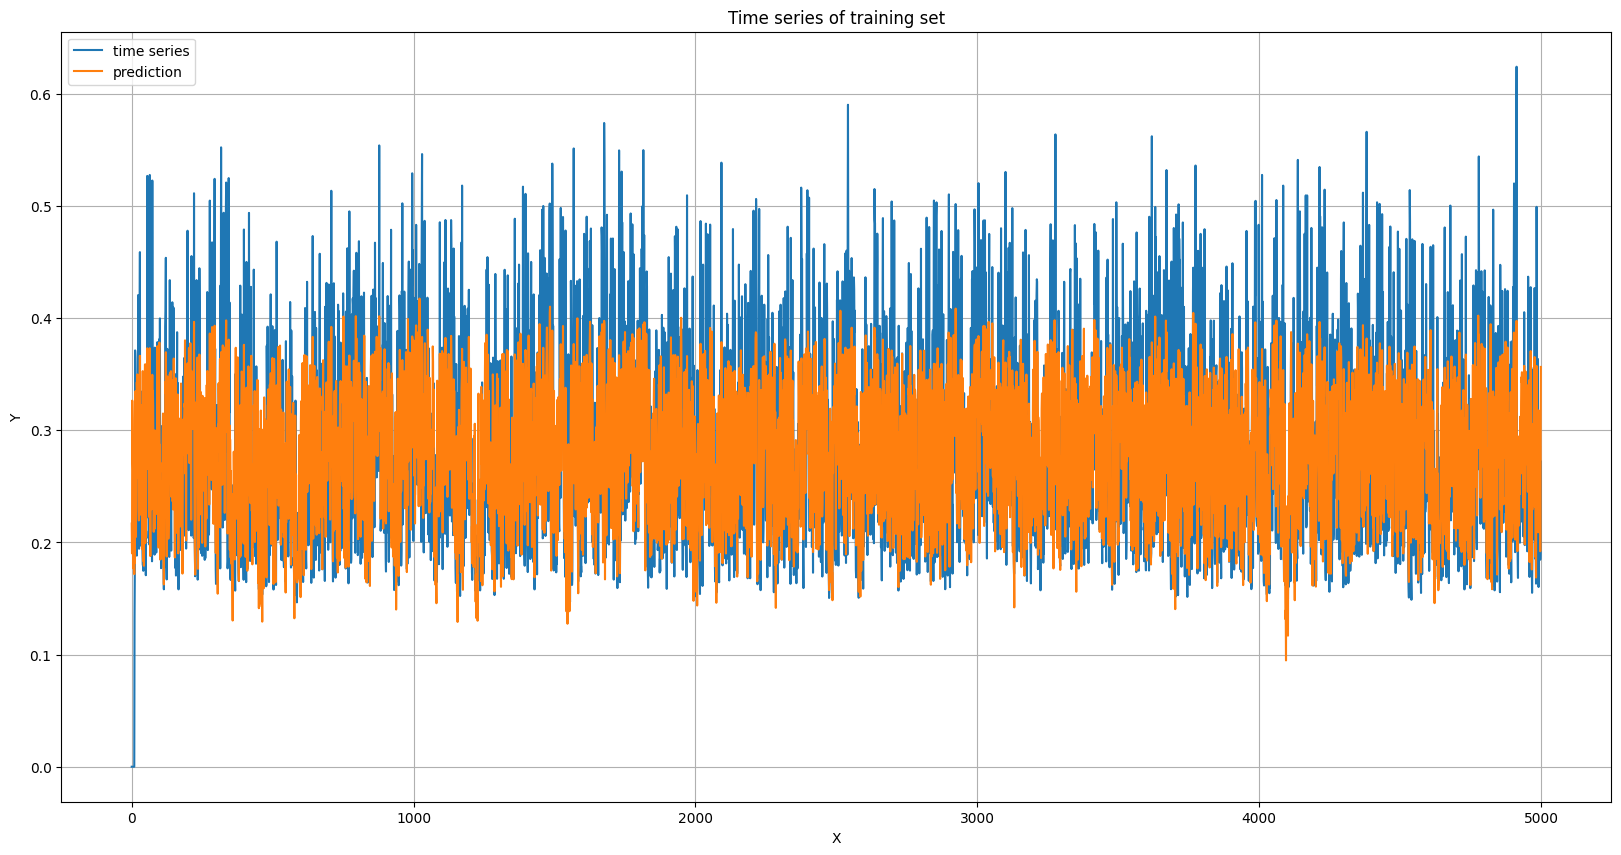

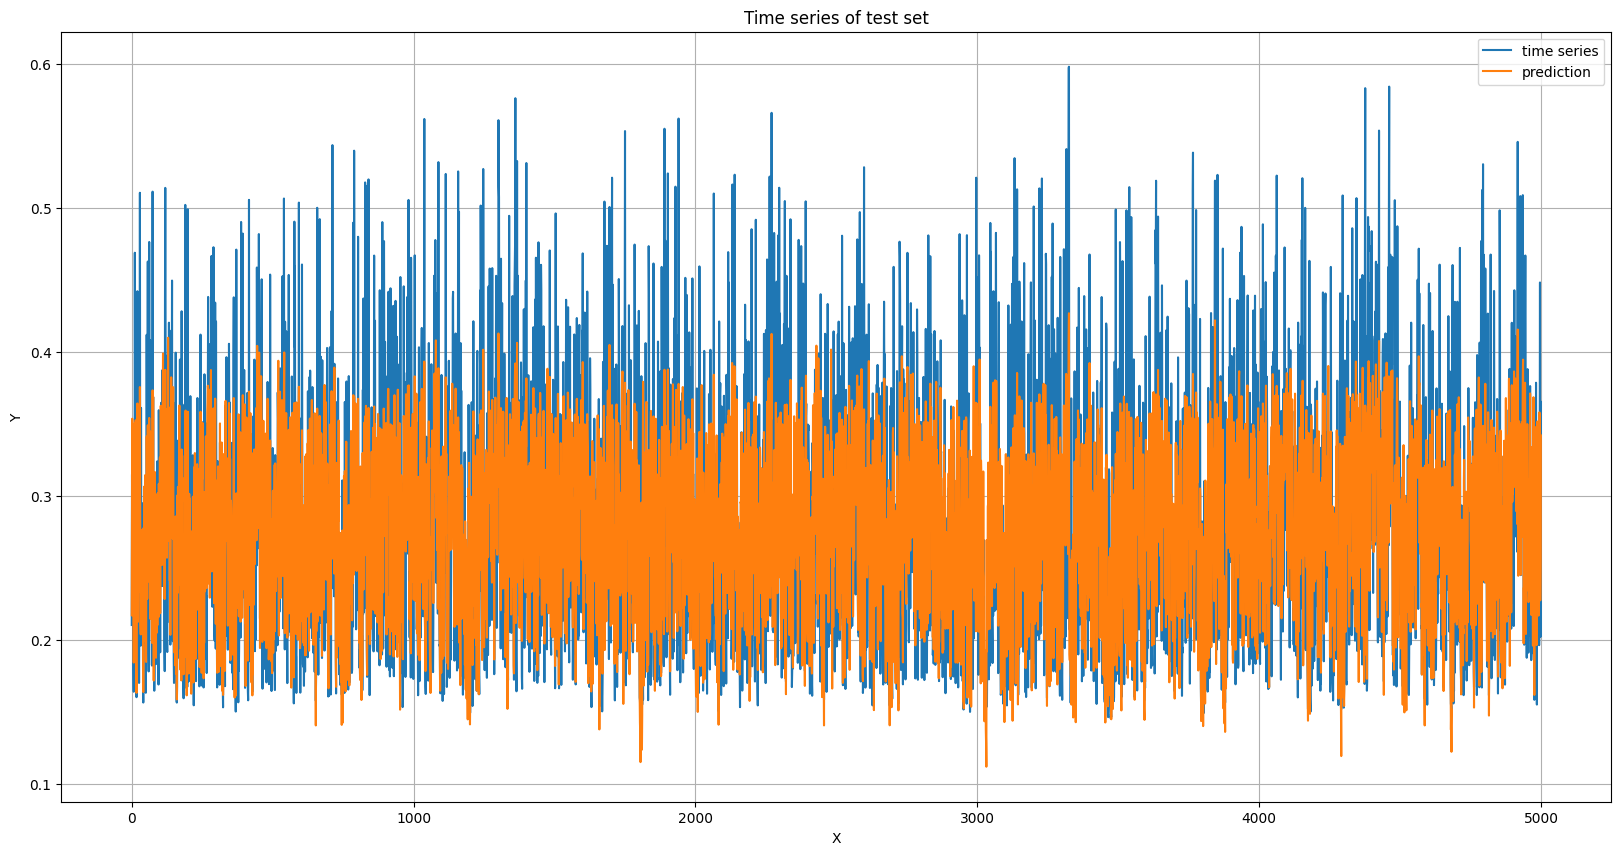

In [9]:
esn_save_name = 'esn_narma10'

narma10_tr_loss, narma10_ts_loss, narma10_tr_preds, narma10_ts_preds = gridsearch(
    configs=dict(
        hidden_size=[50, 100, 200],
        input_scaling=[0.1, 0.5],
        spectral_radius=[0.8, 0.9],
        leakage_rate=[0.2, 0.8], 
        sparsity=[0.9, 0.5],
        reg=[1e-5],
        transient=[100, 150]
    ),
    TR=(TR_X_narma10, TR_Y_narma10),
    TS=(TS_X_narma10, TS_Y_narma10),
    vl_tr_size=4000,
    attempts_for_config=5,
    save_name=esn_save_name,
)

general_plot(TR_Y_narma10.reshape(-1), narma10_tr_preds, TS_Y_narma10.reshape(-1), narma10_ts_preds, save_name=esn_save_name)

# Bonus track 1 - Mackey-glass 17 task

Mackey-glass 17 task dataset loading and split in train and test set.

In [10]:
tr_size = 5000

with open(f'MG17.csv') as file:
    data = file.read().split('\n')[:-1][0]
    data = np.array([float(r) for r in data.split(',')])
    TR_mg17 = data[:tr_size]
    TS_mg17 = data[tr_size:]

TR_X_mg17 = TR_mg17[:-1].reshape(-1, 1, 1)
TR_Y_mg17 = TR_mg17[1:].reshape(-1, 1)
TS_X_mg17 = TS_mg17[:-1].reshape(-1, 1, 1)
TS_Y_mg17 = TS_mg17[1:].reshape(-1, 1)

TR_X_mg17.shape, TR_Y_mg17.shape, TS_X_mg17.shape, TS_Y_mg17.shape

((4999, 1, 1), (4999, 1), (4999, 1, 1), (4999, 1))

ESN gridsearch and results on Mackey-glass 17 dataset.

  0%|          | 0/96 [00:00<?, ?it/s]

1/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, 'spectral_radius': 0.8, 'leakage_rate': 0.2, 'sparsity': 0.9, 'reg': 1e-05, 'transient': 100} with loss 0.0004562199683615433
2/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, 'spectral_radius': 0.8, 'leakage_rate': 0.2, 'sparsity': 0.9, 'reg': 1e-05, 'transient': 150} with loss 0.00042837167939773385
3/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, 'spectral_radius': 0.8, 'leakage_rate': 0.2, 'sparsity': 0.5, 'reg': 1e-05, 'transient': 100} with loss 0.0008420055201340445
4/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, 'spectral_radius': 0.8, 'leakage_rate': 0.2, 'sparsity': 0.5, 'reg': 1e-05, 'transient': 150} with loss 0.0007739241783372261
5/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.1, 'spectral_radius': 0.8, 'leakage_rate': 0.8, 'sparsity': 0.9, 'reg': 1e-05, 'transient': 100} with loss 5.684808654602658e-06
6/96 - Tried config {'hidden_size': 50, 'input_scaling': 0.

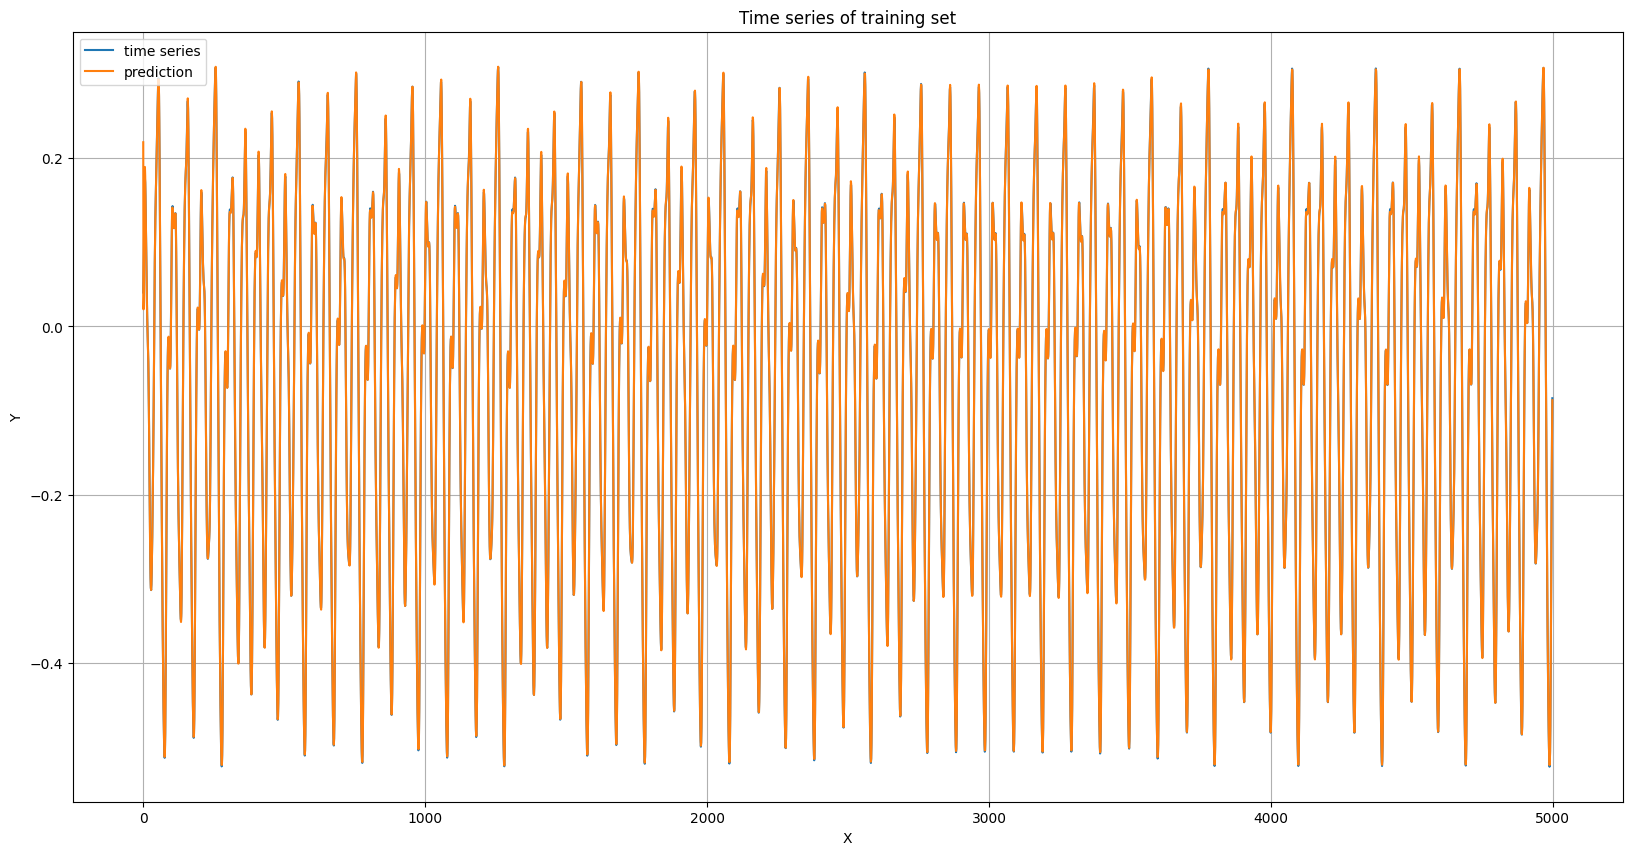

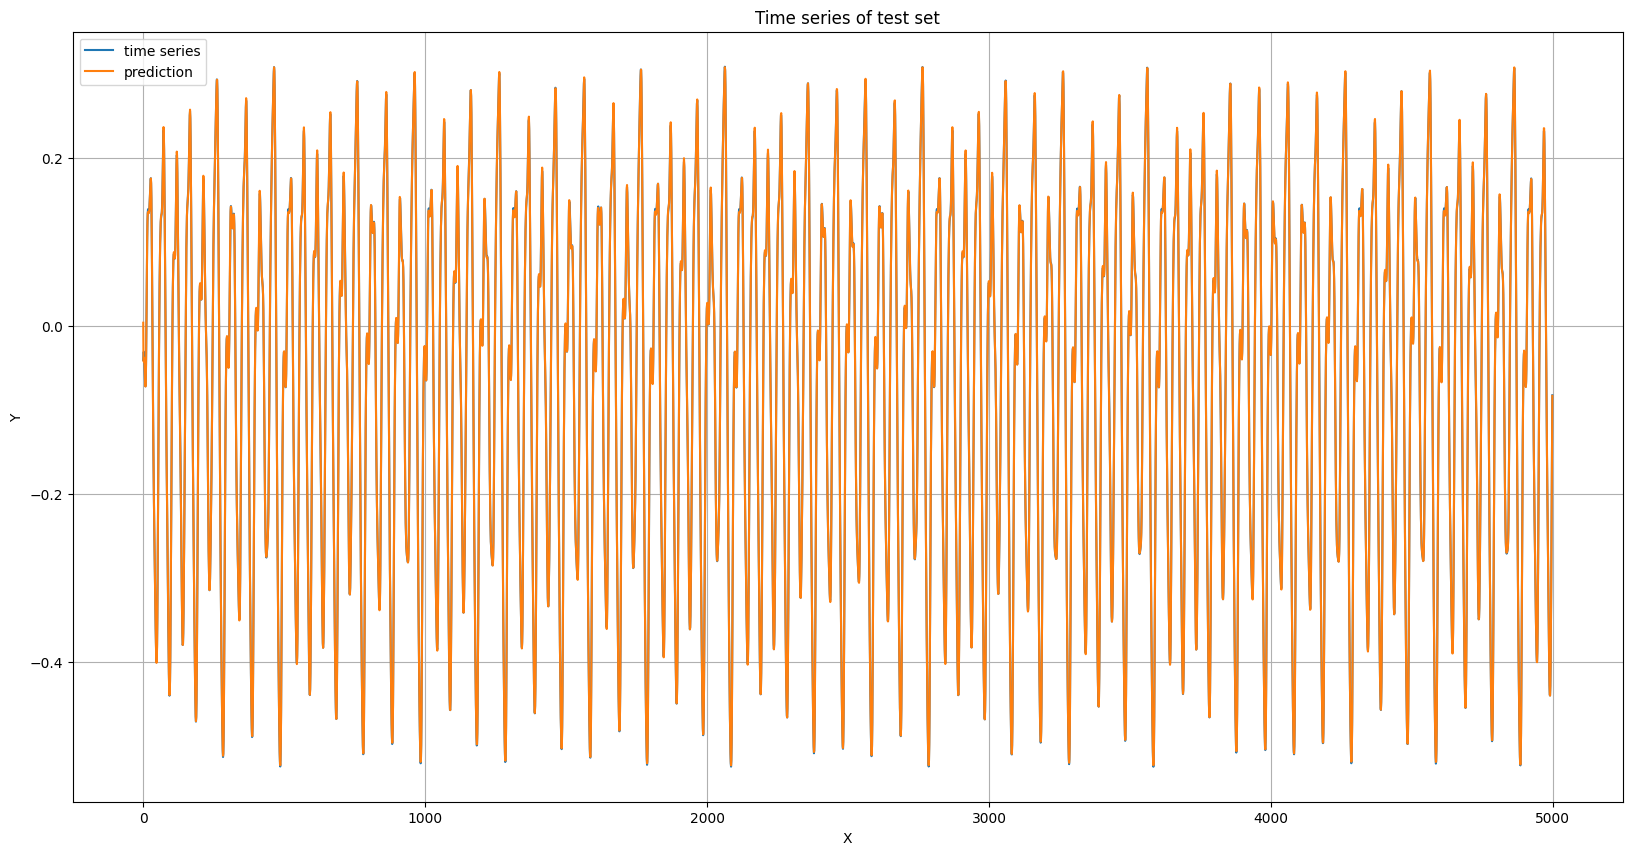

In [11]:
esn_save_name = 'esn_mg17'

mg17_tr_loss, mg17_ts_loss, mg17_tr_preds, mg17_ts_preds = gridsearch(
    configs=dict(
        hidden_size=[50, 100, 200],
        input_scaling=[0.1, 0.5],
        spectral_radius=[0.8, 0.9],
        leakage_rate=[0.2, 0.8], 
        sparsity=[0.9, 0.5],
        reg=[1e-5],
        transient=[100, 150]
    ),
    TR=(TR_X_mg17, TR_Y_mg17),
    TS=(TS_X_mg17, TS_Y_mg17),
    vl_tr_size=4000,
    attempts_for_config=5,
    save_name=esn_save_name,
)

general_plot(TR_Y_mg17.reshape(-1), mg17_tr_preds, TS_Y_mg17.reshape(-1), mg17_ts_preds, save_name=esn_save_name)

# Bonus track 3 - Sequential MNIST classification

MNIST dataset import.

In [12]:
import torch
from torchvision import datasets
import os

def download_mnist() -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Function able to download MNIST dataset and return it.

    returns:
        tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]: Training data and labels and test data and labels of MNIST dataset.
    """
    mnist_dir = 'MNIST/'
    if not os.path.exists(mnist_dir):
        os.mkdir(mnist_dir)
    TR_MNIST = datasets.MNIST(root=f'{mnist_dir}', train=True, download=True, transform=None)
    TS_MNIST = datasets.MNIST(root=f'{mnist_dir}', train=False, download=True, transform=None)
    preprocess_x = lambda x: x.reshape(-1, 28 * 28, 1).transpose(0, 1).contiguous().type(torch.float32) / 255
    return preprocess_x(TR_MNIST.train_data).numpy(), torch.nn.functional.one_hot(TR_MNIST.train_labels).numpy(), \
        preprocess_x(TS_MNIST.test_data).numpy(), torch.nn.functional.one_hot(TS_MNIST.test_labels).numpy()


TR_X_mnist, TR_Y_mnist, TS_X_mnist, TS_Y_mnist = download_mnist()

TR_X_mnist.shape, TR_Y_mnist.shape, TS_X_mnist.shape, TS_Y_mnist.shape

/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/2_semestre/computational neuroscience/assignments/cns_lab/venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/2_semestre/computational neuroscience/assignments/cns_lab/venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/2_semestre/computational neuroscience/assignments/cns_lab/venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/geremiapompei/Library/CloudStorage/OneDr

((784, 60000, 1), (60000, 10), (784, 10000, 1), (10000, 10))

Import Echo State Network classification model.

In [13]:
from src.model.esn_classification import ESNClassification

print(ESNClassification(1, 100, 1))

ESN(w_in: (1, 100), w_hh: (100, 100), bias: (100, 1), w_out: (100, 1))


Function able to compute the accuracy metric.

In [14]:
def accuracy(Y: np.array, P: np.array) -> float:
    """
    Function able to compute the accuracy metric.

    Y: Output tensor.
    P: Predictions teensor.

    returns:
        float: Accuracy value.
    """
    return (Y.argmax(-1) - P.argmax(-1) == 0).sum() / Y.shape[0]

ESN gridsearch and results on MNIST dataset.

In [15]:
esn_save_name = 'esn_mnist'

mnist_tr_loss, mnist_ts_loss, mnist_tr_preds, mnist_ts_preds = gridsearch(
    configs=dict(
        hidden_size=[100],
        input_scaling=[0.5, 0.2],
        spectral_radius=[1.3, 0.9],
        leakage_rate=[0.01, 0.1], 
        sparsity=[0.9],
        reg=[1e-6],
        transient=[None]
    ),
    TR=(TR_X_mnist, TR_Y_mnist),
    TS=(TS_X_mnist, TS_Y_mnist),
    vl_tr_size=int(TR_X_mnist.shape[1] * 0.8),
    attempts_for_config=1,
    save_name=esn_save_name,
    model_constructor=ESNClassification,
)

tr_accuracy = accuracy(TR_Y_mnist, mnist_tr_preds)
ts_accuracy = accuracy(TS_Y_mnist, mnist_ts_preds)
print(f'tr_accuracy: {tr_accuracy} - ts_accuracy: {ts_accuracy}')

  0%|          | 0/8 [00:00<?, ?it/s]

1/8 - Tried config {'hidden_size': 100, 'input_scaling': 0.5, 'spectral_radius': 1.3, 'leakage_rate': 0.01, 'sparsity': 0.9, 'reg': 1e-06, 'transient': None} with loss 0.05361352717177331
2/8 - Tried config {'hidden_size': 100, 'input_scaling': 0.5, 'spectral_radius': 1.3, 'leakage_rate': 0.1, 'sparsity': 0.9, 'reg': 1e-06, 'transient': None} with loss 0.07860202375923786
3/8 - Tried config {'hidden_size': 100, 'input_scaling': 0.5, 'spectral_radius': 0.9, 'leakage_rate': 0.01, 'sparsity': 0.9, 'reg': 1e-06, 'transient': None} with loss 0.05820616623287817
4/8 - Tried config {'hidden_size': 100, 'input_scaling': 0.5, 'spectral_radius': 0.9, 'leakage_rate': 0.1, 'sparsity': 0.9, 'reg': 1e-06, 'transient': None} with loss 0.07580427458993169
5/8 - Tried config {'hidden_size': 100, 'input_scaling': 0.2, 'spectral_radius': 1.3, 'leakage_rate': 0.01, 'sparsity': 0.9, 'reg': 1e-06, 'transient': None} with loss 0.06047058020925253
6/8 - Tried config {'hidden_size': 100, 'input_scaling': 0.2, 

EuSN gridsearch and results on MNIST dataset.

In [16]:
from src.model.eusn_classification import EuSNClassification

eusn_save_name = 'eusn_mnist'

mnist_tr_loss, mnist_ts_loss, mnist_tr_preds, mnist_ts_preds = gridsearch(
    configs=dict(
        hidden_size=[100],
        input_scaling=[0.5, 0.2],
        spectral_radius=[1.3, 0.9],
        step_size=[0.01, 0.1], 
        diffusion_coefficient=[0.01, 0.001],
        sparsity=[0.9],
        reg=[1e-6],
        transient=[None]
    ),
    TR=(TR_X_mnist, TR_Y_mnist),
    TS=(TS_X_mnist, TS_Y_mnist),
    vl_tr_size=int(TR_X_mnist.shape[1] * 0.8),
    attempts_for_config=1,
    save_name=eusn_save_name,
    model_constructor=EuSNClassification,
)

tr_accuracy = accuracy(TR_Y_mnist, mnist_tr_preds)
ts_accuracy = accuracy(TS_Y_mnist, mnist_ts_preds)
print(f'tr_accuracy: {tr_accuracy} - ts_accuracy: {ts_accuracy}')

  0%|          | 0/16 [00:00<?, ?it/s]

1/16 - Tried config {'hidden_size': 100, 'input_scaling': 0.5, 'spectral_radius': 1.3, 'step_size': 0.01, 'diffusion_coefficient': 0.01, 'sparsity': 0.9, 'reg': 1e-06, 'transient': None} with loss 0.039565393914100334
2/16 - Tried config {'hidden_size': 100, 'input_scaling': 0.5, 'spectral_radius': 1.3, 'step_size': 0.01, 'diffusion_coefficient': 0.001, 'sparsity': 0.9, 'reg': 1e-06, 'transient': None} with loss 0.03981420619071793
3/16 - Tried config {'hidden_size': 100, 'input_scaling': 0.5, 'spectral_radius': 1.3, 'step_size': 0.1, 'diffusion_coefficient': 0.01, 'sparsity': 0.9, 'reg': 1e-06, 'transient': None} with loss 0.05693476691989266
4/16 - Tried config {'hidden_size': 100, 'input_scaling': 0.5, 'spectral_radius': 1.3, 'step_size': 0.1, 'diffusion_coefficient': 0.001, 'sparsity': 0.9, 'reg': 1e-06, 'transient': None} with loss 0.06326039808777499
5/16 - Tried config {'hidden_size': 100, 'input_scaling': 0.5, 'spectral_radius': 0.9, 'step_size': 0.01, 'diffusion_coefficient': 